In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import linear_model, preprocessing, tree, model_selection
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor, BaggingClassifier

In [4]:
raw_data = pd.read_csv('conversion_data.csv')

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
raw_data.describe()  ##very skewed data, only 0.032 converted

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
raw_data.sample(19)

,country,age,new_user,source,total_pages_visited,converted
169727,UK,38,1,Direct,1,0
224271,China,26,0,Direct,5,0
21740,UK,25,0,Ads,9,1
215780,China,37,0,Seo,5,0
200970,US,23,1,Seo,9,0
116637,US,22,1,Ads,3,0
173198,China,31,1,Seo,8,0
137467,UK,45,1,Seo,1,0
172430,US,28,1,Ads,3,0
163135,UK,42,0,Seo,17,1


In [8]:
raw_data[['country', 'source']].describe()

,country,source
count,316200,316200
unique,4,3
top,US,Seo
freq,178092,155040


In [9]:
##part1, EDA
for each in raw_data.columns[:5]:
    print(raw_data[raw_data['converted'] == 1].groupby([each]).converted.count()/raw_data.groupby([each]).converted.count())

country
China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
Name: converted, dtype: float64
age
17     0.071607
18     0.066029
19     0.058616
20     0.057109
21     0.053985
22     0.053243
23     0.047990
24     0.045448
25     0.038782
26     0.039767
27     0.033513
28     0.032564
29     0.033621
30     0.028998
31     0.027461
32     0.024802
33     0.023989
34     0.021556
35     0.018394
36     0.019297
37     0.018953
38     0.014158
39     0.017313
40     0.014270
41     0.012342
42     0.013243
43     0.011623
44     0.009943
45     0.012383
46     0.011356
47     0.007987
48     0.009430
49     0.007366
50     0.005900
51     0.006404
52     0.005348
53     0.003190
54     0.001923
55     0.007614
56          NaN
57          NaN
58     0.012121
59          NaN
60     0.021277
61     0.014085
62          NaN
63          NaN
64          NaN
65          NaN
66          NaN
67          NaN
68          NaN
69          NaN
70          NaN
72          

In [10]:
##from the converted rate analysis, we concluded:
##Convert rate: Germany > UK > US > China
##Younger > older (almost like a exponential distribution)
##Age has two erratic values: 111, 123, which will need to be corrected/discarded
##Old user > first time new user
##Ads > Seo > Direct
##More page visited >less page visited (note: 0% conversion for 1 page visit only; 100% conversion for more than 20 visits)

In [11]:
raw_data[raw_data.total_pages_visited == 1].converted.sum()

0

In [12]:
raw_data[raw_data.age == 111]

,country,age,new_user,source,total_pages_visited,converted
295581,UK,111,0,Ads,10,1


KeyboardInterrupt: 

<Figure size 1800x1800 with 0 Axes>

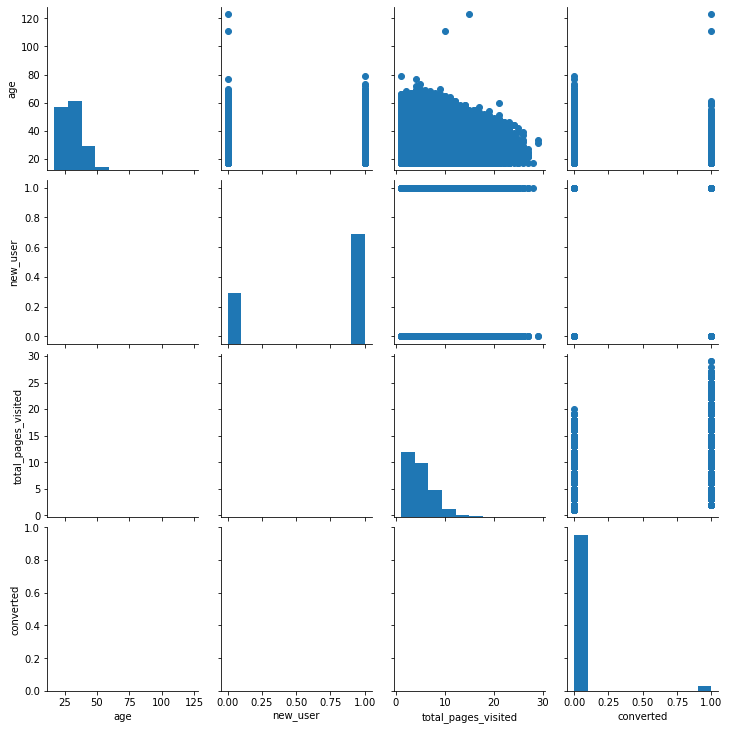

In [13]:
##data visualization overview
plt.figure(figsize=(25,25))
g = sns.PairGrid(raw_data)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

#sns.pairplot(raw_data, hue='converted', palette='rainbow')

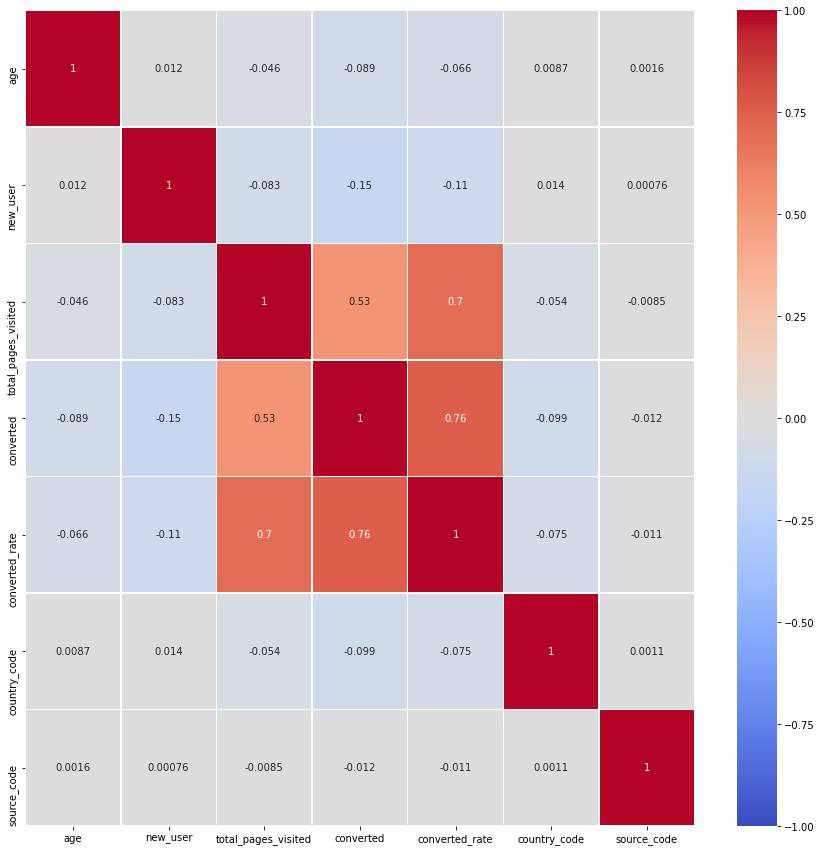

In [77]:
##data visualization heat map
subset = raw_data.sample(1000)
fig = plt.figure(figsize=(15,15))
sns.heatmap(data=raw_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidth=0.5)

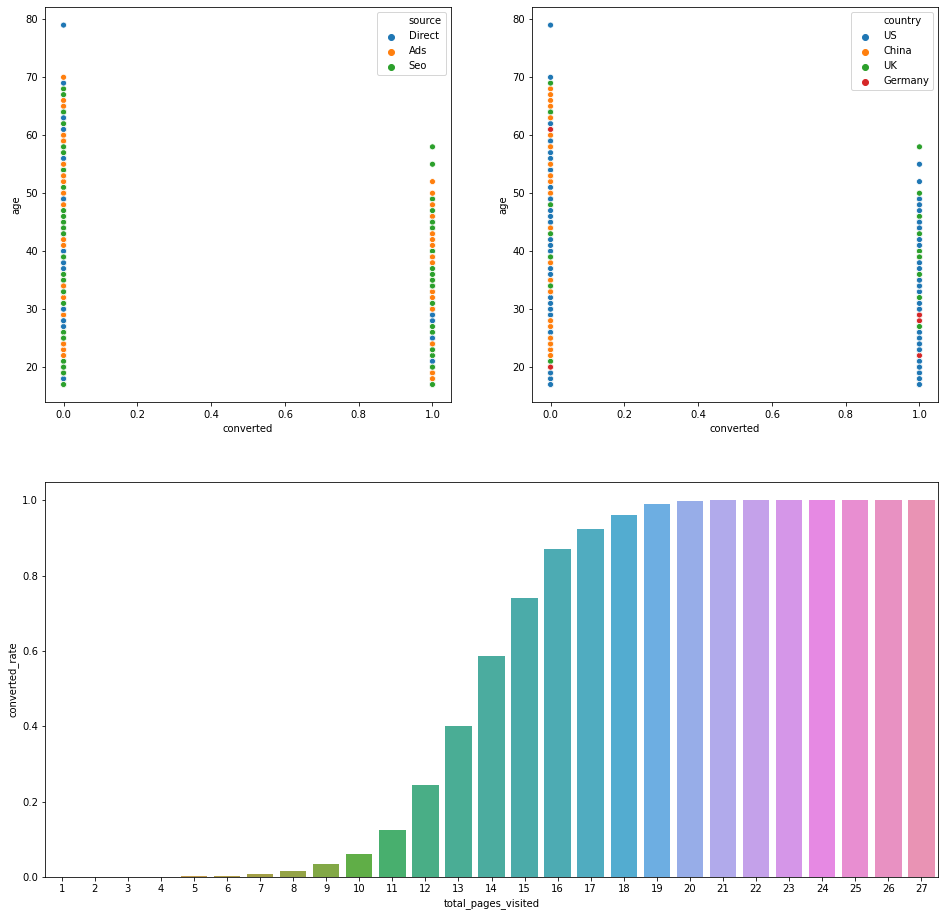

In [14]:
##data visualization relationship
for each in raw_data['total_pages_visited'].unique():
    x = raw_data[raw_data['total_pages_visited'] == each]
    converted_rate = sum(x.converted)/len(x)
    #print(converted_rate, each)
    raw_data.loc[raw_data['total_pages_visited'] == each, 'converted_rate'] = converted_rate

subset = raw_data.sample(50000, random_state=1)
fig = plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
sns.scatterplot(x=subset.converted, y=subset.age, hue=subset.source)
plt.subplot(2,2,2)
sns.scatterplot(x=subset.converted, y=subset.age, hue=subset.country)
plt.subplot(2,1,2)
sns.barplot(x=subset.total_pages_visited,y=subset.converted_rate)
plt.show()

In [15]:
##feature engineering
##1, for the age outliers, doesn't seem to be a typo, so we will discard them.
raw_data.drop(raw_data[raw_data.age == 111].index, inplace=True)
raw_data.drop(raw_data[raw_data.age == 123].index, inplace=True)

In [16]:
raw_data.age.describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

In [17]:
##feature engineering
##2, categorical encoding conversion, will compare labelencoding vs onehotencoding
raw_data.loc[raw_data['country'] == 'Germany', 'country_code'] = 1
raw_data.loc[raw_data['country'] == 'UK', 'country_code'] = 2
raw_data.loc[raw_data['country'] == 'US', 'country_code'] = 3
raw_data.loc[raw_data['country'] == 'China', 'country_code'] = 4

raw_data.loc[raw_data['source'] == 'Ads', 'source_code'] = 1
raw_data.loc[raw_data['source'] == 'Seo', 'source_code'] = 2
raw_data.loc[raw_data['source'] == 'Direct', 'source_code'] = 3

raw_data.sample()

,country,age,new_user,source,total_pages_visited,converted,converted_rate,country_code,source_code
112853,China,31,0,Seo,8,0,0.015238,4.0,2.0


In [18]:
##preliminary feature selection
featurev1 = ['age', 'new_user', 'total_pages_visited', 'country_code', 'source_code']

In [19]:
##data split
train_x, test_x, train_y, test_y = train_test_split(raw_data[featurev1], raw_data['converted'], test_size = 0.15, stratify = raw_data['converted'], random_state=0)

In [20]:
train_x.describe()

,age,new_user,total_pages_visited,country_code,source_code
count,268768.000000,268768.000000,268768.000000,268768.000000,268768.000000
mean,30.568170,0.685543,4.873888,3.007493,1.947624
std,8.264337,0.464300,3.341348,0.748464,0.711994
min,17.000000,0.000000,1.000000,1.000000,1.000000
25%,24.000000,0.000000,2.000000,3.000000,1.000000
50%,30.000000,1.000000,4.000000,3.000000,2.000000
75%,36.000000,1.000000,7.000000,3.000000,2.000000
max,79.000000,1.000000,29.000000,4.000000,3.000000


In [21]:
##modeling
##baseline model with logistic regression

def logiclf(x, y):
    features = x.values
    target = y.values
    
    lr = linear_model.LogisticRegression(max_iter=10000)
    lr_clf = lr.fit(features, target)
    
    bagging = BaggingClassifier(lr, n_estimators=100, random_state=0, oob_score=True, n_jobs=-1)
    bagging_clf = bagging.fit(features, target)
    
    cv_score = model_selection.cross_val_score(lr_clf, features, target, scoring='accuracy', cv=50)
    print('oob_score:', bagging_clf.oob_score_, 'cv50 score:', cv_score.mean())
    print('logistic regression:', lr_clf.score(features, target), 'emsemble:', bagging_clf.score(features, target))
    return lr_clf, bagging_clf
    
start = time.time()
lgclf, bagclf = logiclf(train_x,train_y)
print(time.time() - start)


oob_score: 0.9857200261935944 cv50 score: 0.9857274854651162
logistic regression: 0.9857237468746279 emsemble: 0.9857311882366948
106.02299332618713


In [22]:
print(pd.DataFrame({'columns': featurev1, 'coef': list(lgclf.coef_.T)}))

               columns                    coef
0                  age  [-0.07532201740523851]
1             new_user   [-1.7247550386574573]
2  total_pages_visited    [0.7603275236519482]
3         country_code   [-0.7490185763004685]
4          source_code  [-0.07862694635912348]


In [23]:
lgclf.coef_.tolist()   ##nested array!!!

[[-0.07532201740523851,
  -1.7247550386574573,
  0.7603275236519482,
  -0.7490185763004685,
  -0.07862694635912348]]

               columns  importance
0                  age    0.075322
1             new_user    1.724755
2  total_pages_visited    0.760328
3         country_code    0.749019
4          source_code    0.078627


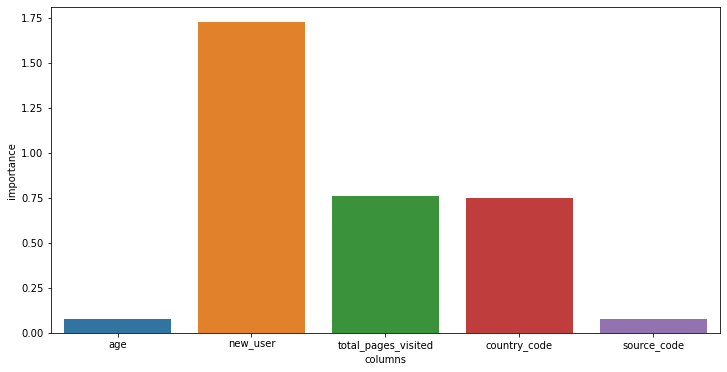

In [24]:
importance = [abs(x) for x in lgclf.coef_.tolist()[0]]

analysis = pd.DataFrame({'columns': featurev1, 'importance': importance})
print(analysis)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=analysis['columns'], y=analysis['importance'])
plt.show()

In [25]:
##QC the prediction on test sets
prediction1 = lgclf.predict(test_x.values)
prediction2 = bagclf.predict(test_x.values)

testqc = test_x.copy(deep=True)
pds1 = pd.Series(prediction1, name='pds1')
pds2 = pd.Series(prediction2, name='pds2')
groundtruth = pd.Series(test_y.values, name='groundtruth')

comb = pd.concat([groundtruth, pds1, pds2], axis=1)
comb['qc1'] = 0
comb.loc[comb.groundtruth == comb.pds1, 'qc1'] = 1
comb['qc2'] = 0
comb.loc[comb.groundtruth == comb.pds2, 'qc2'] = 1


##because the date is extremely skewed, and the overall converted rate is only 0.032, the accuracy rate by guessing all 0 convered will be:
blindguessrate = comb[comb.groundtruth == 0].groundtruth.count()/len(comb)

print('prediction accurate rate on baseline model is:', comb.qc1.sum()/len(comb), 'prediction accurate rate on bagging baseline model is:', comb.qc2.sum()/len(comb), 'best prediction by blind guess is:', blindguessrate)
#print('prediction accuracy rate on test set:', comb.qc.value_counts(normalize=True))


prediction accurate rate on baseline model is: 0.9856209150326798 prediction accurate rate on bagging baseline model is: 0.9856209150326798 best prediction by blind guess is: 0.967741935483871


In [132]:
##logistic regression with polynomial features to test degree
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def polylogtest(x,y):
    features = x.values
    target = y.values
    
    for degree in [1,2,4,6,8]:
        plg = make_pipeline(PolynomialFeatures(degree), linear_model.LogisticRegression())
        plg_clf = plg.fit(features, target)
        cv_score = model_selection.cross_val_score(plg, features, target, scoring='accuracy', cv=50)
        print('polynomial logistic regression with {} degree cv50 score: {}'.format(degree, cv_score.mean()))

start = time.time() 
plgclf = polylogtest(train_x, train_y)
print(time.time() - start)

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

polynomial logistic regression with 1 degree cv50 score: 0.9857013445473348


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

polynomial logistic regression with 2 degree cv50 score: 0.9857332888365677


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

polynomial logistic regression with 4 degree cv50 score: 0.9852509040956925


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

polynomial logistic regression with 6 degree cv50 score: 0.9849825635954204


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=

polynomial logistic regression with 8 degree cv50 score: 0.9677481197309987
3788.372009754181


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
##polynomial logistic regression with 1 degree cv50 score: 0.9857013445473348
##polynomial logistic regression with 2 degree cv50 score: 0.9857332888365677    chosen one
##polynomial logistic regression with 4 degree cv50 score: 0.9852509040956925
##polynomial logistic regression with 6 degree cv50 score: 0.9849825635954204
##polynomial logistic regression with 8 degree cv50 score: 0.9677481197309987
3788.372009754181

In [150]:
##logistic regression with polynomial features degree of 2
def polylog(x,y):
    features = x.values
    target = y.values
    
    plg = make_pipeline(PolynomialFeatures(2), linear_model.LogisticRegression())
    plg_clf = plg.fit(features, target)
    cv_score = model_selection.cross_val_score(plg, features, target, scoring='accuracy', cv=50)
    print('polynomial logistic regression with 2 degree cv50 score: {}'.format(cv_score.mean()))
    return plg_clf
    
start = time.time() 
plgclf = polylog(train_x, train_y)
print(time.time() - start)


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

polynomial logistic regression with 2 degree cv50 score: 0.9857870196566999
177.28944396972656


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [164]:
##QC the prediction on test sets
prediction = plgclf.predict(test_x.values)

pds3 = pd.Series(prediction, name='pds3')

comb2 = pd.concat([comb, pds3], axis=1)
comb2['qc3'] = 0
comb2.loc[comb2.pds1 == comb2.pds3, 'qc3'] = 1
comb2['qc4'] = 0
comb2.loc[comb2.groundtruth == comb2.pds3, 'qc4'] = 1

print('how similar is the polylogistic comparint to baseline:', comb2.qc3.sum()/len(comb2))
print('prediction accurate rate on polylogistic model is:', comb2.qc4.sum()/len(comb2))


how similar is the polylogistic comparint to baseline: 0.998292220113852
prediction accurate rate on polylogistic model is: 0.9854733291165929


In [152]:
print(comb2.loc[comb2.pds != comb2.pds2])   ##originally only 0.01 test sets are selected, and the pds prediction = pds2 prediction in spite of the model difference

       groundtruth  pds  qc  pds2  qc1  qc2
12               0    1   0     0    0    1
223              0    1   0     0    0    1
1181             0    1   0     0    0    1
1472             0    0   1     1    0    0
2022             1    0   0     1    0    1
2126             1    0   0     1    0    1
2884             1    0   0     1    0    1
3621             1    1   1     0    0    0
4062             0    1   0     0    0    1
4350             1    1   1     0    0    0
5048             1    1   1     0    0    0
5296             1    0   0     1    0    1
6103             1    0   0     1    0    1
6192             1    0   0     1    0    1
7166             0    1   0     0    0    1
7379             0    0   1     1    0    0
7426             0    1   0     0    0    1
7543             1    1   1     0    0    0
8195             0    1   0     0    0    1
8633             1    1   1     0    0    0
9480             1    0   0     1    0    1
9727             1    1   1     

In [ ]:
##prediction accurate rate on baseline model is: 0.9856209150326798
##prediction accurate rate on bagging baseline model is: 0.9856209150326798
##prediction accurate rate on polylogistic model is: 0.9854733291165929


In [165]:
##Random forest hyperparameter tuning

def rftuning(x,y):
    features = x.values
    target = y.values
    
    param_grid = {'n_estimators': [300, 600, 800, 1000, 1200, 1500], 'max_depth': [5, 10, 15, 20, 25, 30, 35], 'max_features': [0.4, 0.7, 1], 'random_state': [10]}
    rfclf = RandomForestClassifier()
    model_tune = model_selection.GridSearchCV(rfclf, param_grid=param_grid, cv=10, n_jobs=-1)
    model_tune.fit(features, target)
    print(model_tune.best_params_, model_tune.best_score_)

rftuning(train_x, train_y)

KeyboardInterrupt: 

In [ ]:
##tuning jobs has been running for 6 hours, manually killed it, and use a randome set of parameters for testing

In [166]:
##Random forest

def rf(x,y):
    features = x.values
    target = y.values
    
    rf = RandomForestClassifier(n_estimators=400, max_depth=10, max_features=1, random_state=0)
    rf_clf = rf.fit(features, target)
    cv_score = model_selection.cross_val_score(rf, features, target, scoring='accuracy', cv=50)
    print('Random forest cv50 score: {}'.format(cv_score.mean()))
    return rf_clf

start = time.time() 
rfclf = rf(train_x, train_y)
print(time.time() - start)

Random forest cv50 score: 0.9860139880952381
2508.869679927826


In [167]:
##QC the prediction on test sets
prediction = rfclf.predict(test_x.values)

pds4 = pd.Series(prediction, name='pds4')

comb3 = pd.concat([comb2, pds4], axis=1)
comb3['qc5'] = 0
comb3.loc[comb2.groundtruth == comb3.pds4, 'qc5'] = 1

print('prediction accurate rate on random forest model is:', comb3.qc5.sum()/len(comb3))


prediction accurate rate on random forest model is: 0.9854733291165929


In [169]:
print(comb3.loc[comb3.pds3 != comb3.pds4]) 

       groundtruth  pds1  pds2  qc1  qc2  pds3  qc3  qc4  pds4  qc5
1472             0     0     0    1    1     1    0    0     0    1
1664             1     0     0    0    0     0    1    0     1    1
1758             1     1     1    1    1     1    1    1     0    0
2059             1     0     0    0    0     0    1    0     1    1
2115             0     0     0    1    1     0    1    1     1    0
2233             0     0     0    1    1     0    1    1     1    0
2629             1     0     0    0    0     0    1    0     1    1
2774             1     0     0    0    0     0    1    0     1    1
2884             1     0     0    0    0     1    0    1     0    0
3006             1     0     0    0    0     0    1    0     1    1
3410             1     1     1    1    1     1    1    1     0    0
4031             1     1     1    1    1     1    1    1     0    0
4043             1     1     1    1    1     1    1    1     0    0
4062             0     1     1    0    0     0  

In [ ]:
##prediction accurate rate on baseline model is: 0.9856209150326798
##prediction accurate rate on bagging baseline model is: 0.9856209150326798
##prediction accurate rate on polylogistic model is: 0.9854733291165929
##prediction accurate rate on random forest model is: 0.9854733291165929

In [170]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb

target = train_y.values
features = train_x.values

space = {'n_estimators': hp.quniform('n_estimators', 300, 4000, 100),
         'gamma' : hp.uniform('gamma', 0.01, 0.1),
         'learning_rate': hp.uniform('learning_rate', 0.0001, 0.05),
         'max_depth': hp.quniform('max_depth', 3, 15, 1),
         'subsample': hp.uniform('subsample', 0.3, 1),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def Xgbtuning(space):
    
    reg = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'], learning_rate=space['learning_rate'], reg_lambda=space['reg_lambda'], subsample=space['subsample'])
    ##reg.fit(features, target, eval_set=evaluation, eval_metric="rmse",early_stopping_rounds=10,verbose=False)  need training/test set to evaluate the early stopping, since we are using hyperopt to evaluate the hyperparamerters
    #reg.fit(features, target)
    cvscore = model_selection.cross_val_score(reg, features, target, scoring='accuracy', cv=10, n_jobs=-1).mean()
    #print(cvscore)
    return -cvscore
#Xgbtuning(space)

best = fmin(fn=Xgbtuning, space=space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest, trials=Trials())
print(best)

  0%|                                   | 0/20 [29:47<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [171]:
##XGBOOST

def xgboost(x,y):
    features = x.values
    target = y.values
    
    xgboost = xgb.XGBClassifier(gamma=0.05, learning_rate=0.005, max_depth=10, n_estimators=1200)
    xgb_clf = xgboost.fit(features, target, eval_metric='rmse', verbose=False)
    cvscore = model_selection.cross_val_score(xgboost, features, target, scoring='accuracy', cv=10, n_jobs=-1).mean()
    print(cvscore)
    
    return xgb_clf

start = time.time() 
xgbclf = xgboost(train_x, train_y)
print(time.time() - start)

0.9858130450990421
997.6510033607483


In [172]:
##QC the prediction on test sets
prediction = xgbclf.predict(test_x.values)

pds5 = pd.Series(prediction, name='pds5')

comb4 = pd.concat([comb3, pds5], axis=1)
comb4['qc6'] = 0
comb4.loc[comb4.groundtruth == comb4.pds5, 'qc6'] = 1

print('prediction accurate rate on XGBOOST model is:', comb4.qc6.sum()/len(comb4))


prediction accurate rate on XGBOOST model is: 0.9854522454142948


In [173]:
##Random forest

def rf(x,y):
    features = x.values
    target = y.values
    
    rf = RandomForestClassifier(random_state=0)
    rf_clf = rf.fit(features, target)
    cv_score = model_selection.cross_val_score(rf, features, target, scoring='accuracy', cv=50)
    print('Random forest cv50 score: {}'.format(cv_score.mean()))
    return rf_clf

start = time.time() 
rfclf = rf(train_x, train_y)
print(time.time() - start)

Random forest cv50 score: 0.9847154581949059
1001.9658534526825


In [26]:
test_y.describe()
comb.pds1.describe()

count    47430.000000
mean         0.025469
std          0.157547
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pds1, dtype: float64

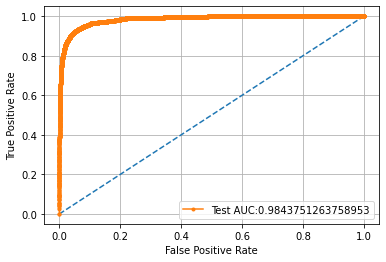

AUC for the best model is: 0.9843751263758953
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45900
           1       0.85      0.67      0.75      1530

    accuracy                           0.99     47430
   macro avg       0.92      0.83      0.87     47430
weighted avg       0.98      0.99      0.98     47430



In [50]:
##confusion matrix and ROC curve
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

y_scores = lgclf.decision_function(test_x.values)
fpr, tpr, thresholds = roc_curve(test_y, y_scores)
auc = roc_auc_score(test_y, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the best model is:',auc)
print(classification_report(y_true=test_y.values, y_pred=comb.pds1))


In [51]:
y_scores

array([-8.54804951, -8.62337153, -8.84603265, ..., -6.19925145,
       -6.55324364, -4.45277519])

In [61]:
prob = lgclf.predict_proba(test_x.values)
log_prob= lgclf.predict_log_proba(test_x.values)

print(prob.min(),prob.max())
print(log_prob.min(),log_prob.max())

1.3269572491197705e-06 0.9999986730427509
-13.532622019320216 -1.3269581294900444e-06


In [75]:
y_scores.size
y_score_new = prob[:,1]     ####both y_score_new and y_scores work for the ROC curves
print(y_score_new,y_scores)

[0.00019389 0.00017982 0.00014393 ... 0.00202683 0.00142346 0.01151213] [-8.54804951 -8.62337153 -8.84603265 ... -6.19925145 -6.55324364
 -4.45277519]


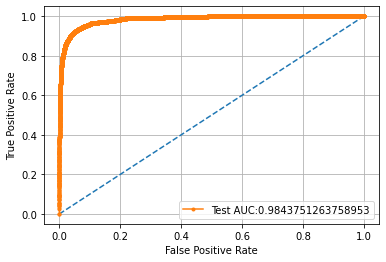

AUC for the best model is: 0.9843751263758953
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45900
           1       0.85      0.67      0.75      1530

    accuracy                           0.99     47430
   macro avg       0.92      0.83      0.87     47430
weighted avg       0.98      0.99      0.98     47430



In [76]:
fpr, tpr, thresholds = roc_curve(test_y, y_score_new)
auc = roc_auc_score(test_y, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the best model is:',auc)
print(classification_report(y_true=test_y.values, y_pred=comb.pds1))


In [ ]:
###Summary, without being able to tune the hyperparameters for random forest and XGBOOST, our baseline model gives the best prediction result

##As for the recommendations for product team and marketing team:
##The more converted rate comes from:
##1, non-first-time users did more purchase: increase the revisit rate by sending followup emails with promo? 
##2, people browsing more items tend to pruchase: need to improve the recommender system to show more relevant or demanded items
##3, yonger age users did more purchase: should target on the yonger user groups(<35yo)
##4, germany users have higher convert rate: maybe try to attract more Germany than Chinese? 
##5, as for the marketing approaches: direct visit has lowest convert rate, coming from off-line promotion? consider decrease it?